# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [121]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from collections import deque
from sklearn.neighbors import KDTree
import sklearn.metrics as metrics
import math
from time import time



In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

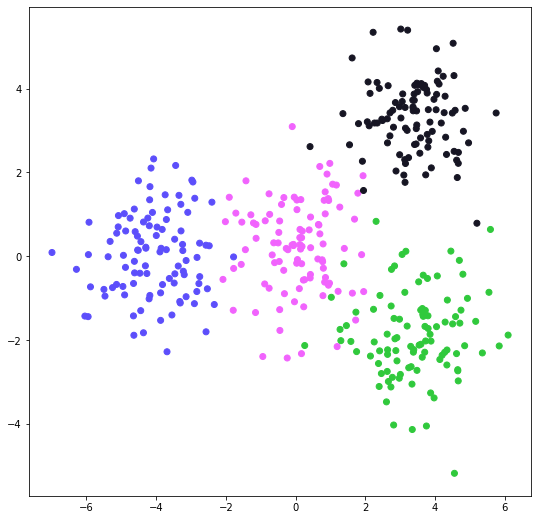

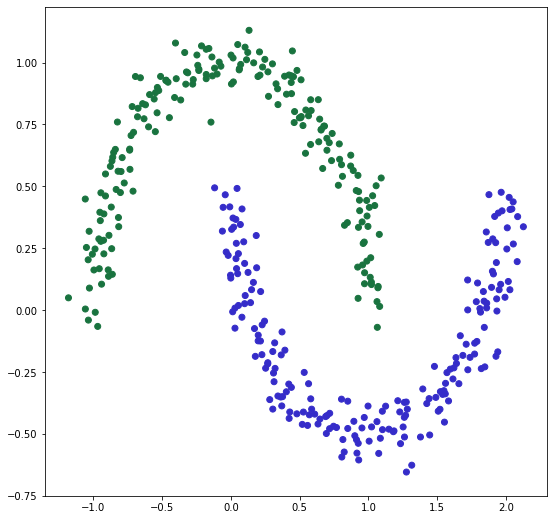

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (2 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [4]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = np.array([[]])

    def fit(self, X, y=None):
        if self.init == 'random':
            min_x, min_y = X.min(axis=0)
            max_x, max_y = X.max(axis=0)
            self.centroids = np.array([[random.uniform(min_x, max_x), random.uniform(min_y, max_y)] for i in range (self.n_clusters)])
        elif self.init == 'self.init == random':
            self.centroids = np.array([X[random.randint(0, len(X) - 1)] for i in range (self.n_clusters)])
        else:
#           посчитаем квадратые расстояний до ближайших центроидов - distances

            self.centroids = np.array([X[random.randint(0, len(X) - 1)]])
            while len(self.centroids) < self.n_clusters:
            
                distances = [(-1) for i in range (len(X))]
                sum_of_dist = 0
                
                for index in range(len(X)):
                    for c in self.centroids: 
                        cur_dist = (c[0] - X[index][0]) ** 2 + (c[1] - X[index][1]) ** 2
                        if distances[index] == -1 or distances[index] > cur_dist:
                            distances[index] = cur_dist
                    sum_of_dist += distances[index]
#               пропорционально квадрату расстояния выберем следующий центроид
                random_pointer = random.uniform(0, sum_of_dist)
                sum_of_dist = 0
                index_of_new_centroid = -1
            
                while sum_of_dist < random_pointer:
                    index_of_new_centroid += 1
                    sum_of_dist+=distances[index_of_new_centroid]
                self.centroids = np.append(self.centroids, [X[index_of_new_centroid]], axis=0)
            
    def predict(self, X):
#       X_clusters[i] - номер кластера, к которому относится i-й элемент
        X_clusters = [(-1) for i in range (len(X))]
        for i in range(self.max_iter):
    #       Относим каждую точку к ближайшему для нее кластеру
            for index in range(len(X)):
                cluster_index = 0
                min_dist = -1
                for c_in in range(len(self.centroids)): 
                    cur_dist = (self.centroids[c_in][0] - X[index][0]) ** 2 + (self.centroids[c_in][1] - X[index][1]) ** 2
                    if min_dist == -1 or min_dist > cur_dist:
                        min_dist = cur_dist
                        cluster_index = c_in
                X_clusters[index] = cluster_index
    #       Двигаем центры кластеров в центры масс
            cluster_coord_sum = np.array([[0, 0] for i in range (self.n_clusters)])
            cluster_amount_of_dots = np.array([0 for i in range (self.n_clusters)])
            for i in range(len(X_clusters)):
                cluster_coord_sum[X_clusters[i]][0] += X[i][0]
                cluster_coord_sum[X_clusters[i]][1] += X[i][1]
                cluster_amount_of_dots[X_clusters[i]] += 1
            self.centroids = (cluster_coord_sum.transpose() / cluster_amount_of_dots).transpose()
        return X_clusters
        
            

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

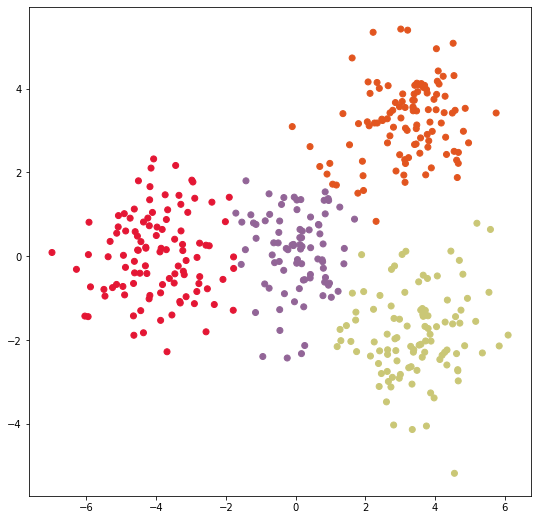

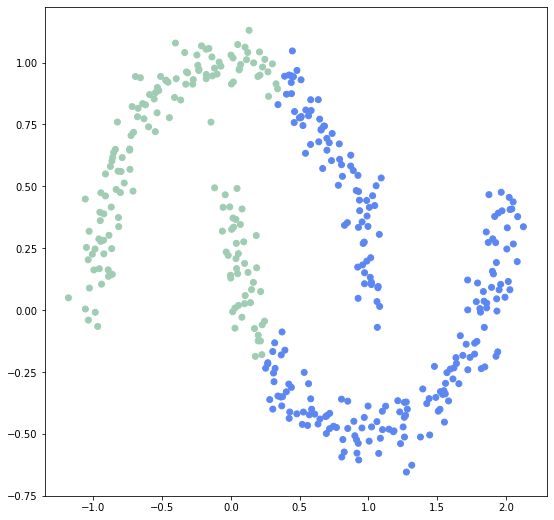

In [5]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [94]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_sample = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        

    def fit_predict(self, X, y=None):
#       tree - KD-дерево соседей
#       X_clusters[i] - номер кластера, к которому относится i-й элемент
#       index - индекс, который поучим от дерева, если получии от дерева ind, то обращаемся к X: X[index[ind]]
#       color - актуальный номер цвета(кластера)
        self.X = X
        self.tree = KDTree(X, leaf_size=self.leaf_size, metric = self.metric)
        self.X_clusters = [-1 for i in range (len(X))]
        self.index = [i for i in range (len(X))]
        color = 0;
#       Заполняем - является ли точка основной (соседей нужное количество, или нет)
        self.X_main_pts = [x >= self.min_sample for x in self.tree.query_radius(X, r=self.eps, count_only=True)]
        for i in range(len(X)):
            if self.X_main_pts[i] and self.X_clusters[i] == -1:
                self.X_clusters[i] = color
                self.tree_traversal(color, X[i])
                color += 1
        return self.X_clusters
    
#       Ходим по построенному дереву рекурсивно:
    def tree_traversal(self, color, x):
        for ind in self.tree.query_radius([x], r=self.eps)[0]:
#           X[self.index[self.ind]] - сосед
            i = self.index[ind]
            if  self.X_clusters[i] == -1:
                self.X_clusters[i] = color
                if self.X_main_pts[i]:
                    self.tree_traversal(color, self.X[i])
        

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

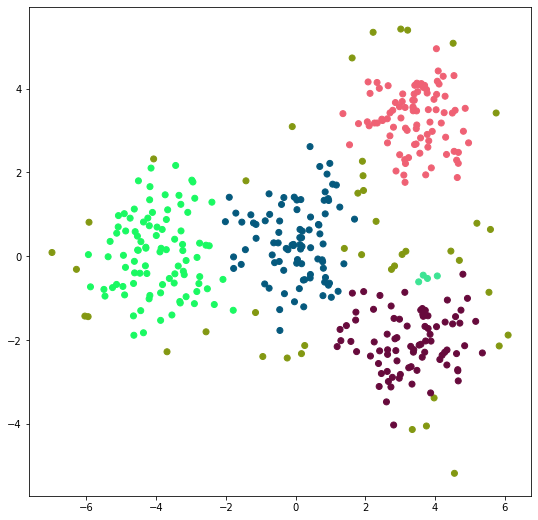

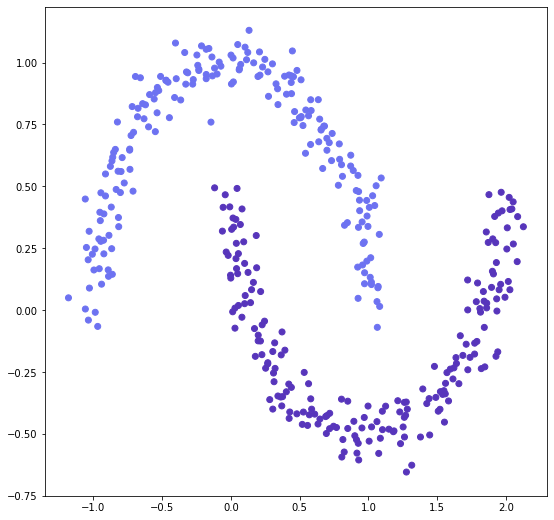

In [123]:
# Для первой фигуры - оптимальынм оказалось 0.6 - 0.7, но иногда бывают чуть чуть кривости из-за разброса
# если начать менять min_samples, то беда.
dbscan = DBScan(eps = 0.61)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

# Тут все супер
dbscan = DBScan(eps = 0.2)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

# Если что, выбросы - красятся отдельным цветом


### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [146]:
class AgglomertiveClustering:
    def __init__(self, n_clusters = 16, linkage = "average"):
        self.n_clusters = n_clusters
        self.linkage = linkage
        
    def get_cluster_by_color(self, color):
        cluster = []
        for i in range(len(self.X)):
            if self.X_clusters[i] == color:
                cluster.append(self.X[i])
        return cluster
    
    def distance_two_points(self, a, b):
        return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
        
    
    def distance_two_clusters(self, cluster_a, cluster_b):
        if self.linkage == 'average':
            total_dist = 0
            total_pairs = 0
            for a in cluster_a:
                for b in cluster_b:
                    total_dist += self.distance_two_points(a, b)
                    total_pairs += 1
            return total_dist/total_pairs
        if self.linkage == 'single':
            min_dist = -1
            for a in cluster_a:
                for b in cluster_b:
                    dist = self.distance_two_points(a, b)
                    if dist < min_dist or min_dist == -1:
                        min_dist = dist
            return min_dist
        if self.linkage == 'complete':
            max_dist = -1
            for a in cluster_a:
                for b in cluster_b:
                    dist = self.distance_two_points(a, b)
                    if dist > max_dist:
                        max_dist = dist
            return max_dist
        
    def make_normal_colors(self):
        # Получается матрица из цветов с разным индексам, сделаем цвета от 0
        x_set = set(self.X_clusters)
        new_col_map = {}
        i_col = 0
        for col in x_set:
            new_col_map.update({col:i_col})
            i_col+=1
        new_X_clusters = []
        for x in self.X_clusters:
            new_X_clusters.append(new_col_map[x])
        return new_X_clusters
        
    
    def fit_predict(self, X, y = None):
#       X_clusters[i] - номер кластера (цвет), к которому относится i-й элемент
        self.X_clusters = [i for i in range (len(X))]
        self.X = X
        set_of_colors = set(self.X_clusters)
        cur_cluster_amount = len(X)
#       ищем минимально разбросанные кластеры до тех пор, пока не дойдем до нужного количества кластеров
             
        while len(set_of_colors) > self.n_clusters:
            
            col_cluster = {}
            for col in set_of_colors:
                col_cluster.update({col: self.get_cluster_by_color(col)})
            
            min_dist = -1
            min_a = -1
            min_b = -1
            list_of_colors = list(set_of_colors)
            for i in range(len(list_of_colors)):
                a = list_of_colors[i]
                cluster_a = col_cluster[a]
                for j in range(i+1, len(list_of_colors)):
                    b = list_of_colors[j]
                    dist = self.distance_two_clusters(col_cluster[a], col_cluster[b])
                    if dist < min_dist or min_dist == -1:
                        min_dist = dist
                        min_a = a
                        min_b = b

#           нашли самые близкие кластеры, теперь покрасим оба в один цвет (все в min_a)
            for i in range(len(self.X_clusters)):
                if self.X_clusters[i] == min_b:
                    self.X_clusters[i] = min_a
          
            set_of_colors.remove(min_b)
        return self.make_normal_colors()

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

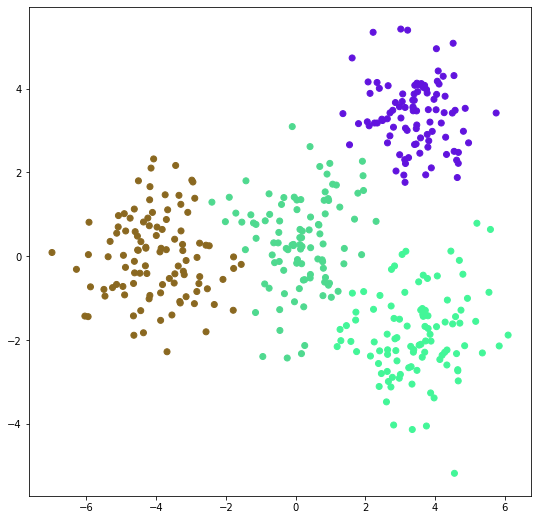

Время выполнения: 104.07733535766602 sec


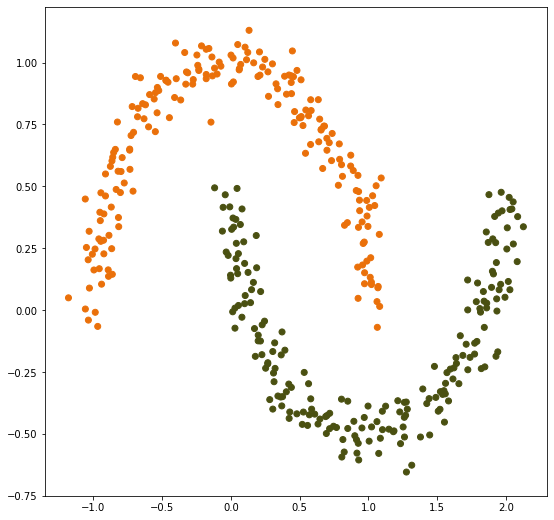

Время выполнения: 70.74409341812134 sec


In [149]:
# Стало интересно время выполнения


tic = time()
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)


toc = time() 
print('Время выполнения: '+str(toc - tic)+' sec')
tic = time()

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage = 'single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

toc = time() 
print('Время выполнения: '+str(toc - tic)+' sec')